In [1]:
import cclib
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants

from overreact import core, thermo, rates, simulate

%matplotlib inline

In [2]:
jmol = constants.physical_constants["Hartree energy"][0] * constants.N_A
jmol

2625499.6394798253

I want to reproduce the results of [this paper](https://doi.org/10.1002/qua.25686):

$$\require{mhchem}\ce{CH4 + Cl^{.} <=> RC -> RC^{\ddagger} <=> CH3^{.} + HCl}$$

In [3]:
scheme = core.parse("""
    CH4 + Cl. <=> RC -> RC* -> PC <=> CH3. + HCl
""")
scheme

Scheme(compounds=['CH4', 'Cl.', 'RC', 'RC*', 'PC', 'CH3.', 'HCl'], reactions=['CH4 + Cl. -> RC', 'RC -> CH4 + Cl.', 'RC -> PC', 'PC -> CH3. + HCl', 'CH3. + HCl -> PC'], is_half_equilibrium=array([ True,  True, False,  True,  True]), A=array([[-1.,  1.,  0.,  0.,  0.],
       [-1.,  1.,  0.,  0.,  0.],
       [ 1., -1., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -1.,  1.],
       [ 0.,  0.,  0.,  1., -1.],
       [ 0.,  0.,  0.,  1., -1.]]), B=array([[-1.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.],
       [ 1.,  0., -1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]]))

Now let's read some data from files:

In [4]:
logfiles = {
    "CH4": cclib.ccopen("../../data/Dzib_2018/ch4.out").parse().getattributes(),
    "RC": cclib.ccopen("../../data/Dzib_2018/reactants.out").parse().getattributes(),
    "RC*": cclib.ccopen("../../data/Dzib_2018/ts.out").parse().getattributes(),
    "PC": cclib.ccopen("../../data/Dzib_2018/products.out").parse().getattributes(),
    "CH3.": cclib.ccopen("../../data/Dzib_2018/ch3.out").parse().getattributes(),
    "HCl": cclib.ccopen("../../data/Dzib_2018/hcl.out").parse().getattributes(),
#     "Cl.": cclib.ccopen("../../data/Dzib_2018/cl.out").parse().getattributes(),
    "Cl.": {
        "enthalpy": -459.62856787 - 0.00283260,
        "entropy": 0.00065446 + 0.01740262,  # S(el) + S(vib) + S(rot) + S(trans)
    },
}
logfiles["Cl."]["freeenergy"] = logfiles["Cl."]["enthalpy"] - logfiles["Cl."]["entropy"]

freeenergy = np.array([logfiles[compound]["freeenergy"] for compound in scheme.compounds])
freeenergy

array([ -40.36982099, -459.64945755, -500.01497634, -499.99897386,
       -500.00998076,  -39.71365855, -460.30383376])

In [5]:
Gconc = constants.R * 298.15 * np.log(constants.atm / (constants.R * 298.15))
Gconc / 4184.0

2.1984125935789756

The below is just to remind myself that the enthalpy and entropy come out subtractively contributing to the free energy in ORCA!

In [6]:
logfiles["CH4"]["enthalpy"] - logfiles["CH4"]["entropy"] == logfiles["CH4"]["freeenergy"]

True

Some barriers, which will then be adjusted for molecularity (if needed, it's easier to adjust the absolute Gibbs energies by ):

In [7]:
barriers = thermo.get_delta_freeenergy(scheme.B, freeenergy * jmol + Gconc)
barriers / 4184

array([ 0.50125867,  0.        , 10.04170781, -2.5151562 ,  0.        ])

In [8]:
molecularity = np.sum(np.where(scheme.A < 0, -scheme.A, 0), axis=0)
molecularity

array([2., 1., 1., 1., 2.])

In [9]:
k = rates.eyring(barriers)
k

array([2.66585740e+12, 6.21243799e+12, 2.70794079e+05, 4.33395455e+14,
       6.21243799e+12])

In [10]:
1e-6 * k[2] * k[0] / k[1]

0.11620210967211467

In [11]:
scheme.reactions

['CH4 + Cl. -> RC',
 'RC -> CH4 + Cl.',
 'RC -> PC',
 'PC -> CH3. + HCl',
 'CH3. + HCl -> PC']

array([0.08997128, 0.08997128, 0.00347225, 0.        , 0.01148404,
       0.89507239, 0.89507239])

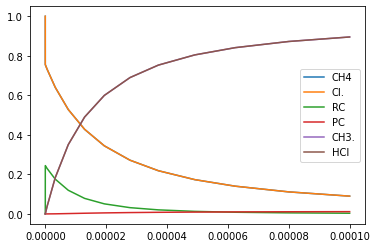

In [12]:
dydt = simulate.get_dydt(scheme, k)
t, y = simulate.get_y(dydt, y0=[1.0, 1.0, 0.0, 0.0, 0., 0., 0.], t_span=[0.0, 1.0e-4], method="Radau")

for i, compound in enumerate(scheme.compounds):
    if not compound.endswith("*"):
        plt.plot(t, y[i], label=compound)
plt.legend()

y[:, -1]

(-5000.0, 5000.0)

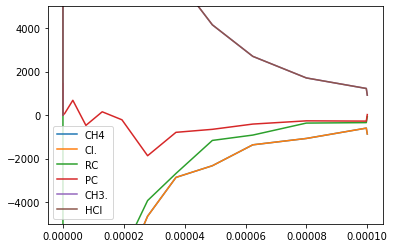

In [13]:
dydt_vals = np.array([dydt(t, yt) for yt in y.T])

for i, compound in enumerate(scheme.compounds):
    if not compound.endswith("*"):
        plt.plot(t, dydt_vals.T[i], label=compound)
plt.legend()

plt.ylim(-5e3, 5e3)